In [61]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import primed_utils
from primed_data_processing.cellbuilder import CellBuilder

# Import Data

In [2]:
# instantiate CellBuilder
cell_builder = CellBuilder()

# raws_prepath = 'path/to/raws/'
raws_prepath = 'C:/Users/seanb/OneDrive/Documents/PRIMED/export/batdat/MTC/raws/'

# all channel and cell numbers from B6 in order
channel_numbers = (1,2,3,4,9,10,11,12,13,14,15,16)
cell_numbers = (9,10,11,12,1,2,3,4,5,6,7,8)
steps = {'characterization': [6,10]}

# load Arbin data
batch = primed_utils.load_B6T10(cell_builder, raws_prepath, channel_numbers, cell_numbers, steps)

Processing channel 1
Processing channel 2
Processing channel 3
Processing channel 4
Processing channel 9
Processing channel 10
Processing channel 11
Processing channel 12
Processing channel 13
Processing channel 14
Processing channel 15
Processing channel 16


# Data Processing

In [13]:
# calculate and assing SOH's to all of the steps
primed_utils.assign_cell_cycle_numbers(batch)
primed_utils.assign_soh(6, 10, 4, batch)
primed_utils.assign_soh(10, 10, 4, batch)
primed_utils.assign_temp(6, 6, batch, default_temp_idx=0)
primed_utils.assign_temp(10, 10, batch, default_temp_idx=0)

# filter into bins of 1% soh
step6_filtered = primed_utils.filter_by_temp(6, (20,23), batch)
step6_filtered = primed_utils.filter_by_soh(step6_filtered, 1, soh_lower=69,soh_upper=97)
step10_filtered = primed_utils.filter_by_temp(10, (20,23), batch)
step10_filtered = primed_utils.filter_by_soh(step10_filtered, 1, soh_lower=69,soh_upper=97)

# Plotting Functions

In [57]:
def plot_ocv(step, feature, nom_cap):
    plt.plot(np.array(step[feature])/nom_cap, step['Voltage(V)'])
    plt.xlabel('SOC')
    plt.ylabel('Voltage')
    plt.xlim(0,1)

def plot_ocvs(steps, feature, nom_cap):
    plt.figure()
    for step in steps:
        plt.plot(np.array(step[feature])/nom_cap, step['Voltage(V)'], label=f"{step.soh} {step.channel_number}")
    plt.xlabel('SOC')
    plt.ylabel('Voltage')
    plt.xlim(0,1)
    plt.legend()

def plot_ocv_array(filtered_steps, feature, nom_cap,save=False):
    nrows = int(len(filtered_steps.keys()) / 4)
    ncols = 4

    col_labels = [f"SOC" for j in range(ncols)]

    for i, key in enumerate(filtered_steps.keys()):
        if i % ncols == 0:
            fig, ax = plt.subplots(1, ncols, sharey='row', figsize=(20, 9))

            for ax_col, col_label in zip(ax, col_labels):
                ax_col.annotate(col_label, xy=(0.5, 1.1), xycoords='axes fraction',
                                ha='center', va='center', fontsize=12)

        col = i % ncols

        for step in filtered_steps[key]:
            ax[col].plot(np.array(step[feature]) / nom_cap, step['Voltage(V)'],
                         label=f"SOH: {round(step.soh, 2)} Chan: {step.channel_number}")

        if i % ncols == 3:
            ax[0].set_ylabel("Voltage (V)")
            for ax in fig.axes:
                ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.25), ncol=2)

            plt.tight_layout()
            if save:
                plt.savefig(f"C:\\Users\\seanb\\repos\\battery_sizing_model\\Images\\discharge_by_soh{i//4 + 1}.png")
    plt.show()
    
def plot_avg_ocv(interpolated_x, avg_dict, actual_dict, soh_key, feature):
    for step in actual_dict[soh_key]:
        plt.plot(np.array(step[feature]) / 4.0, step["Voltage(V)"], alpha=0.5, linestyle='-.')
    plt.plot(interpolated_x, avg_dict[soh_key])
    plt.xlabel("SOC")
    plt.ylabel("Voltage (V)")
    

# Inspect OCV Curves

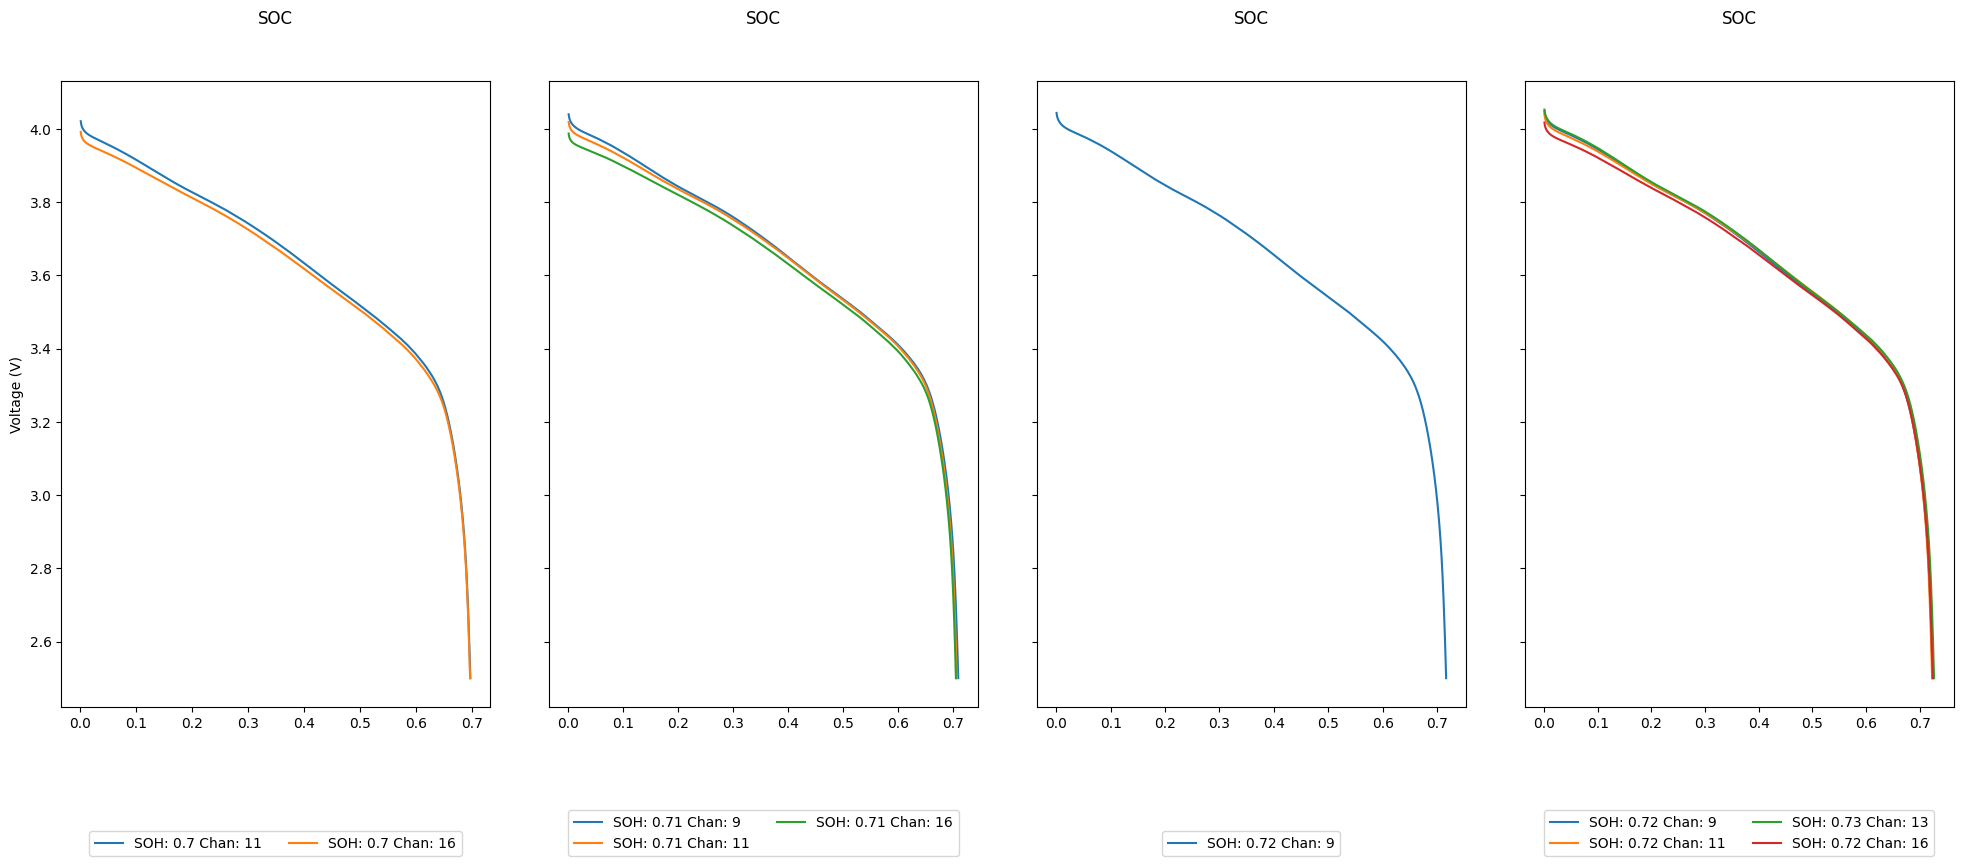

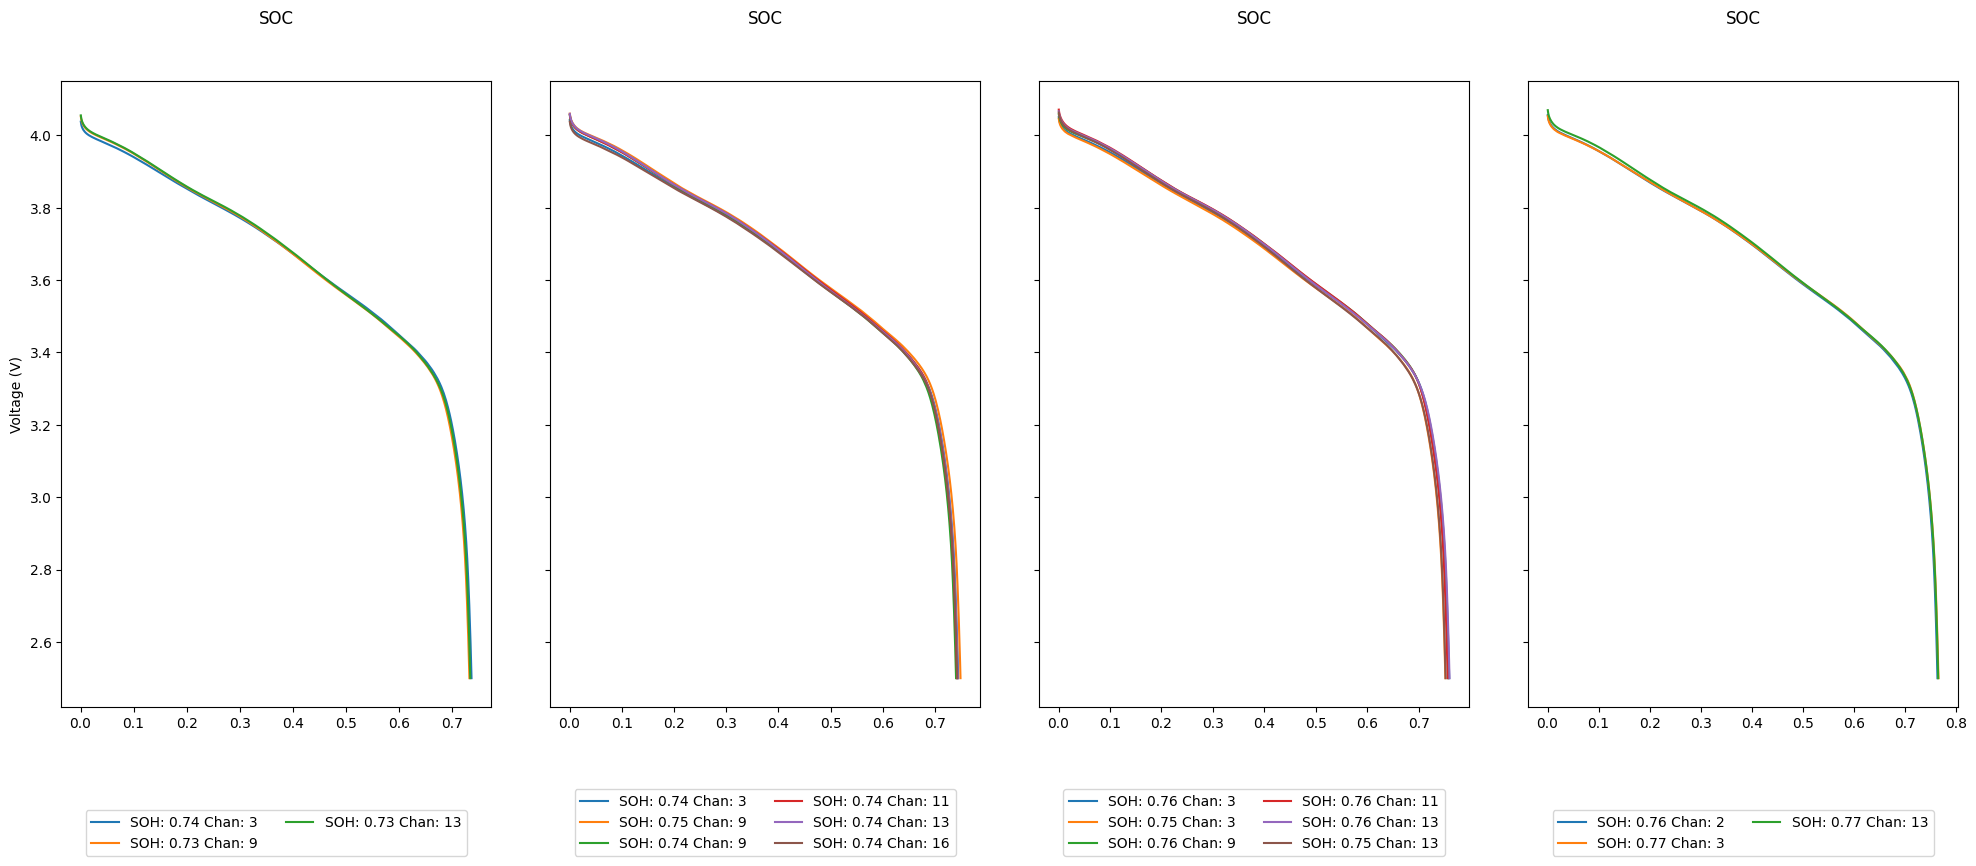

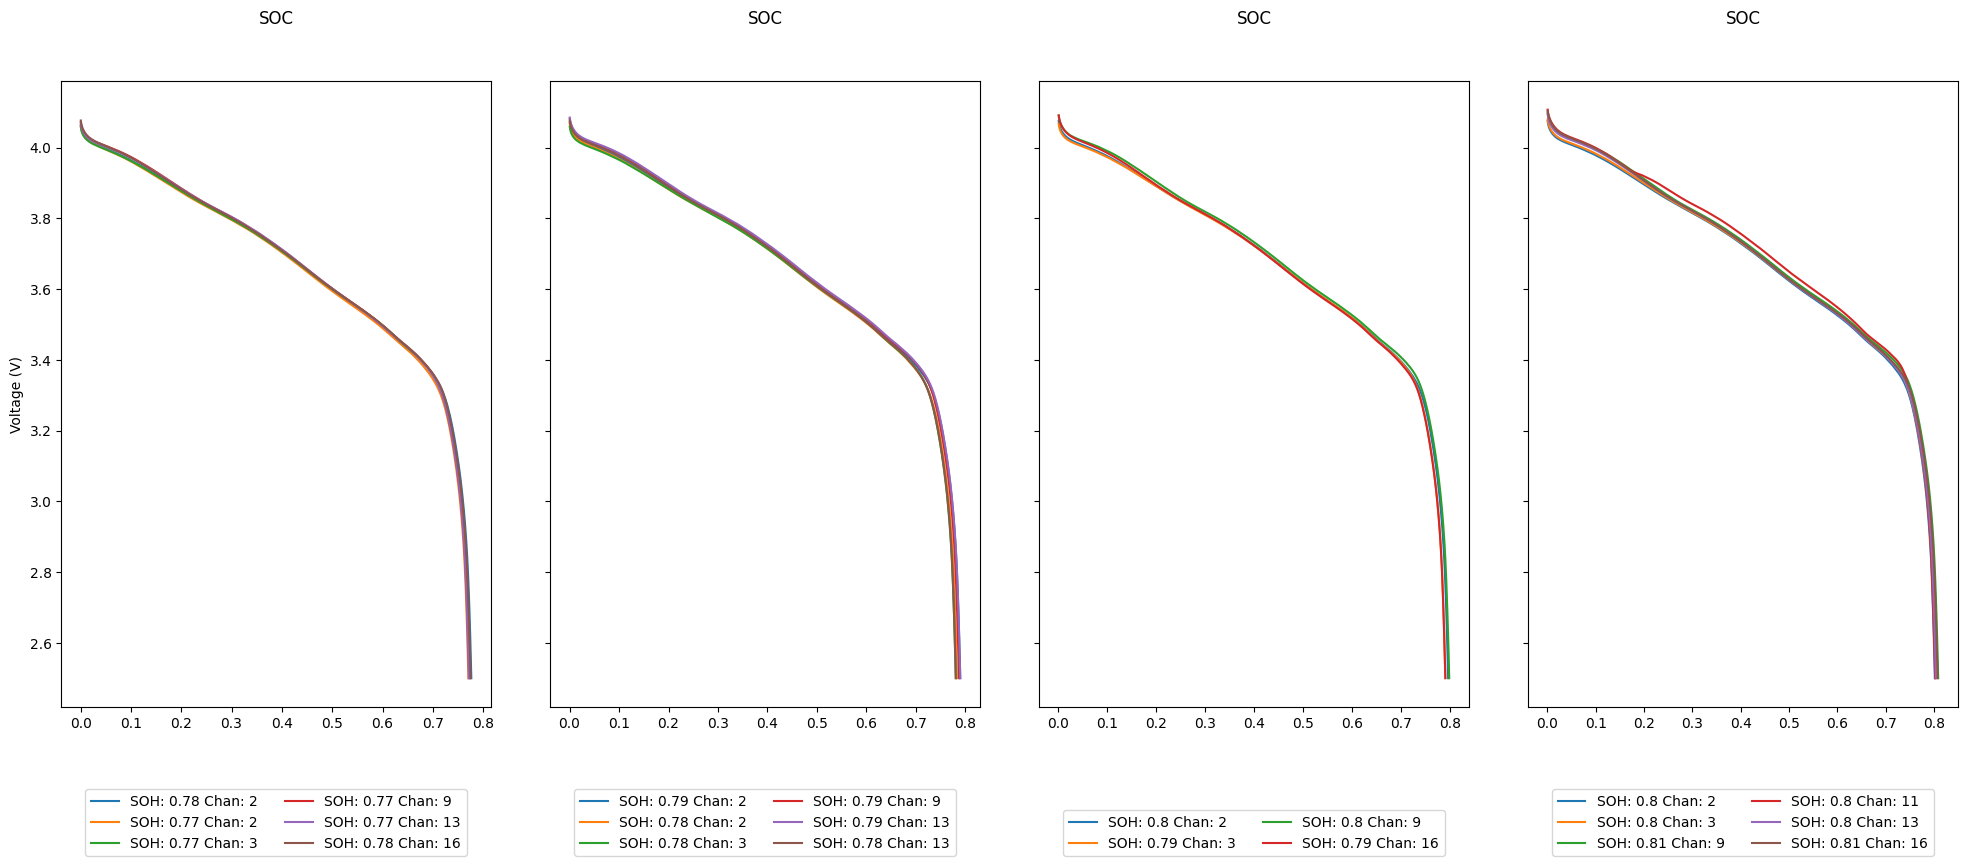

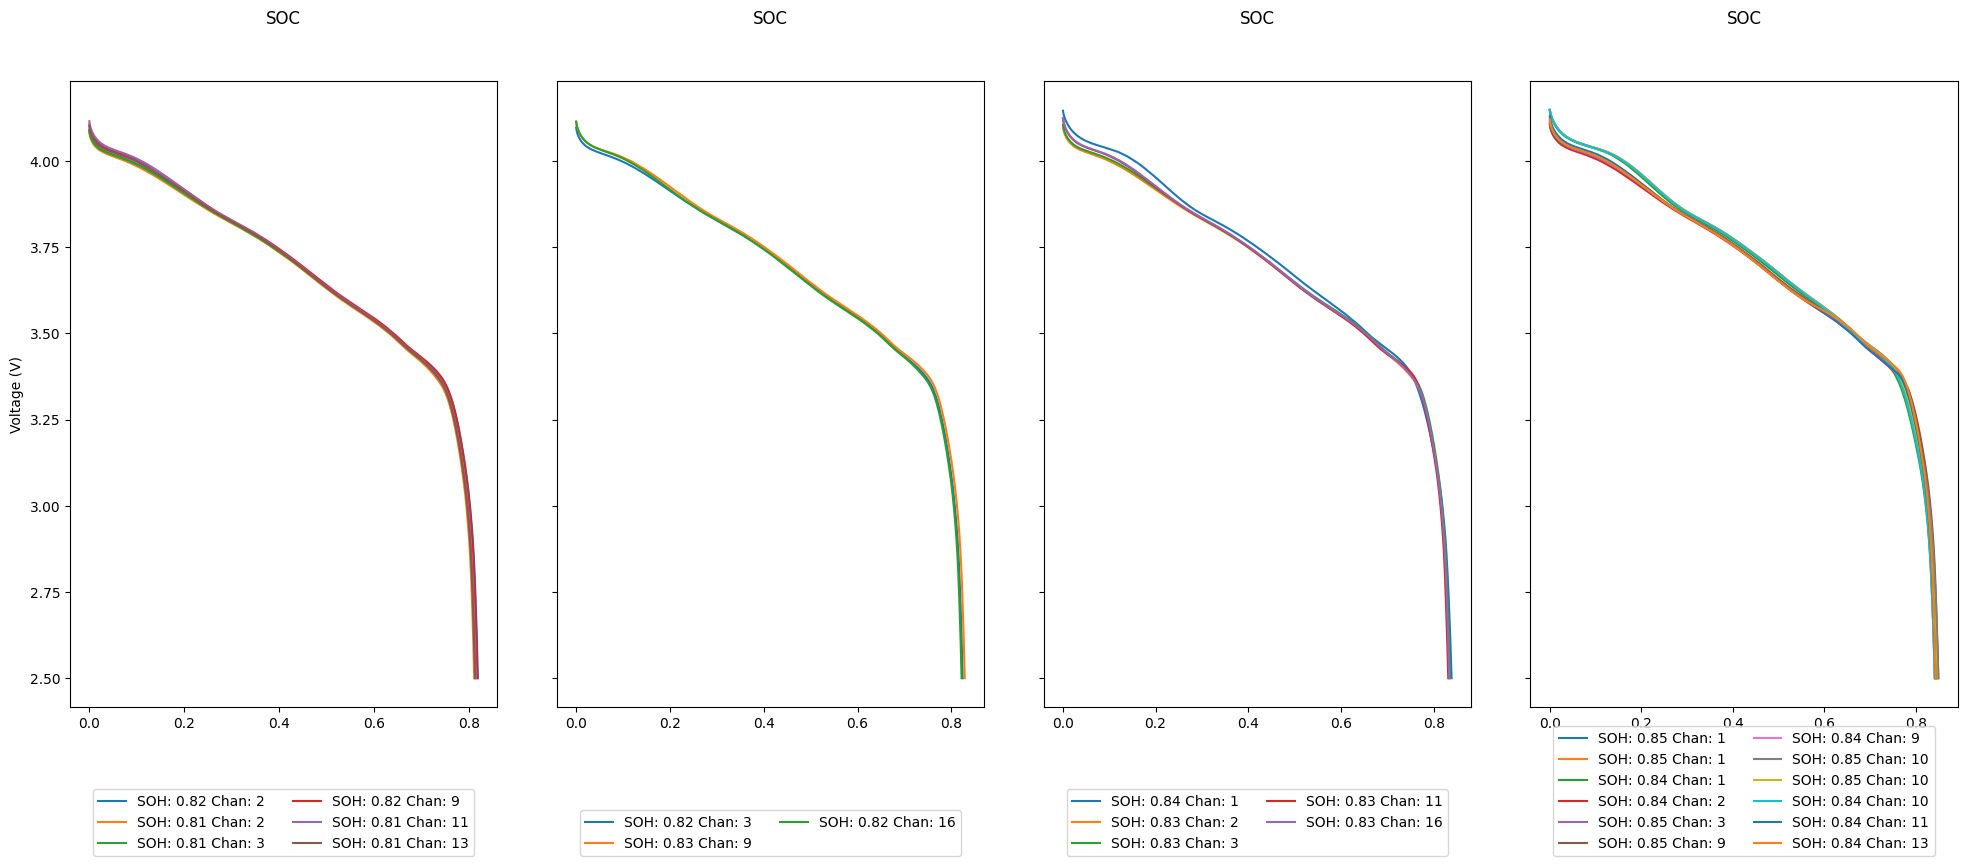

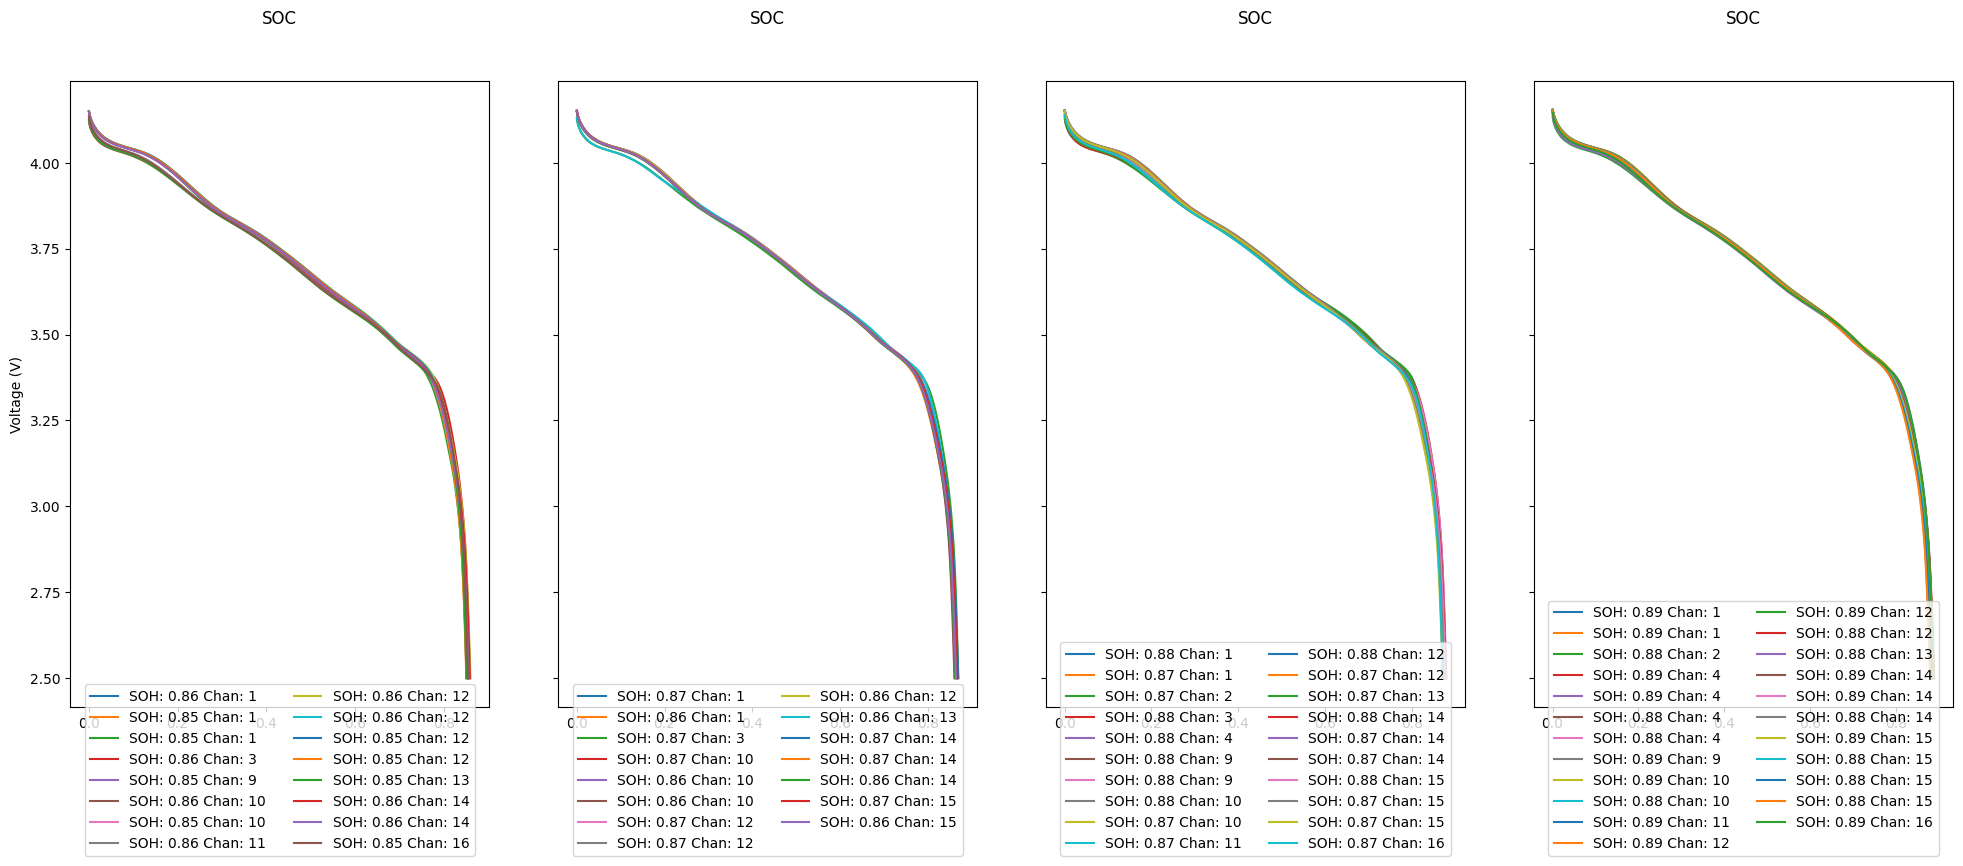

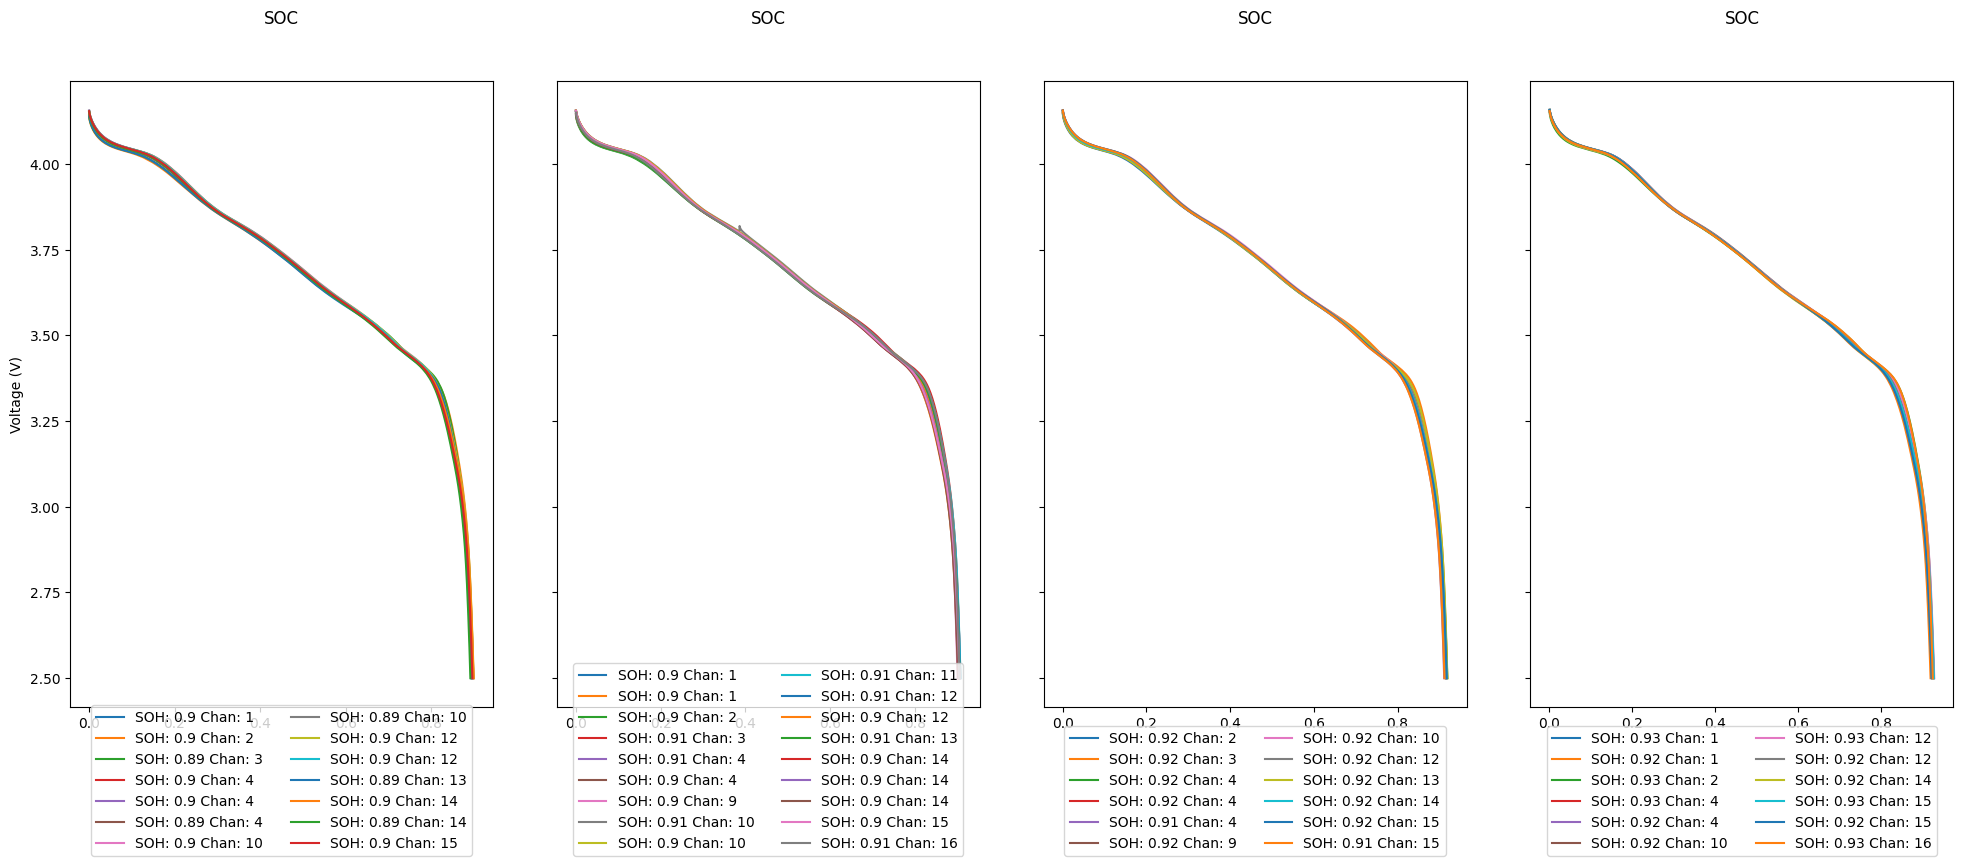

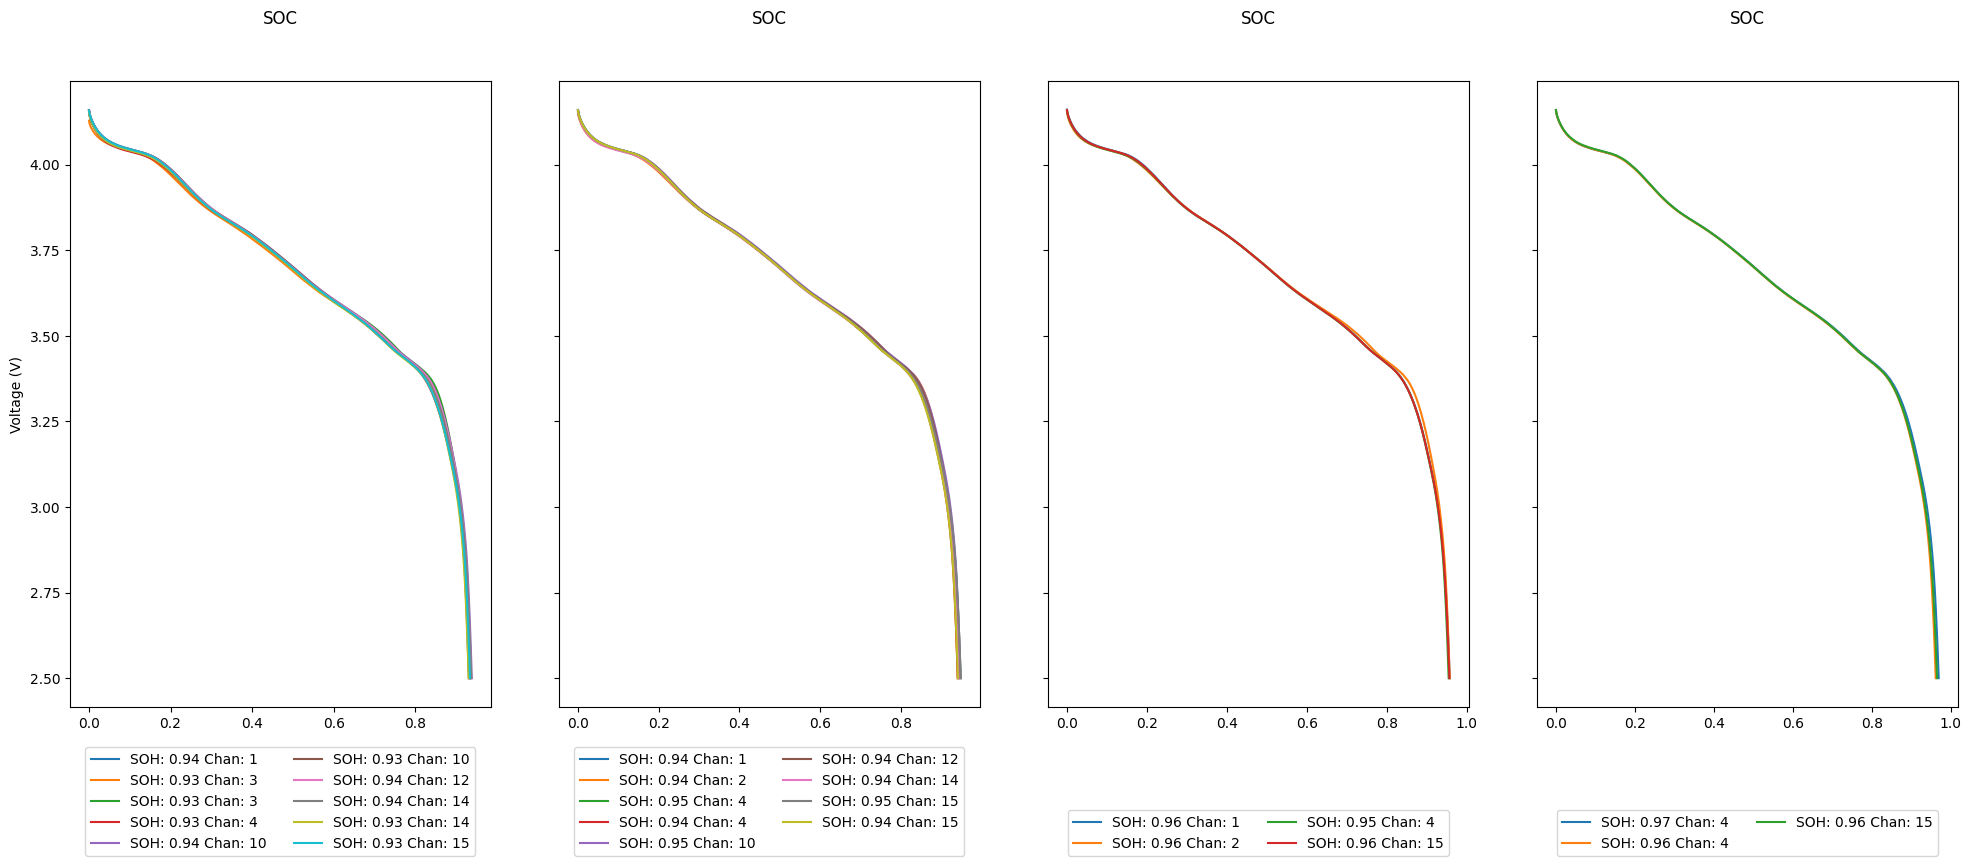

In [16]:
plot_ocv_array(step10_filtered,"Discharge_Capacity(Ah)",4)

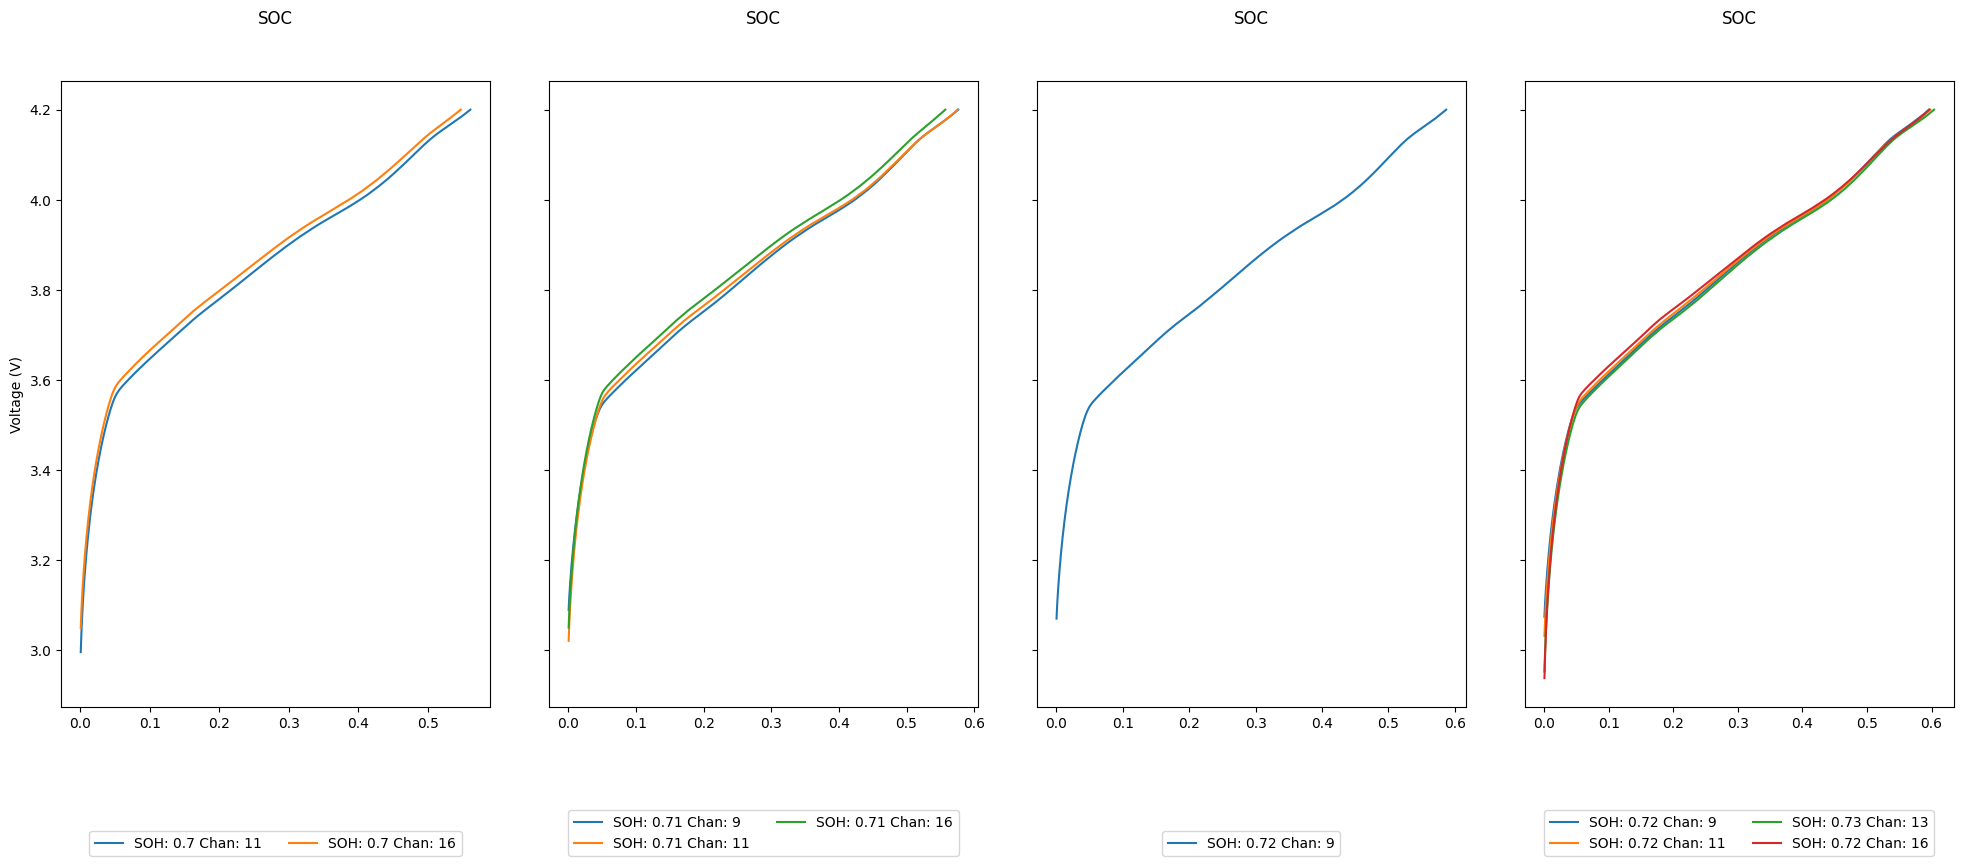

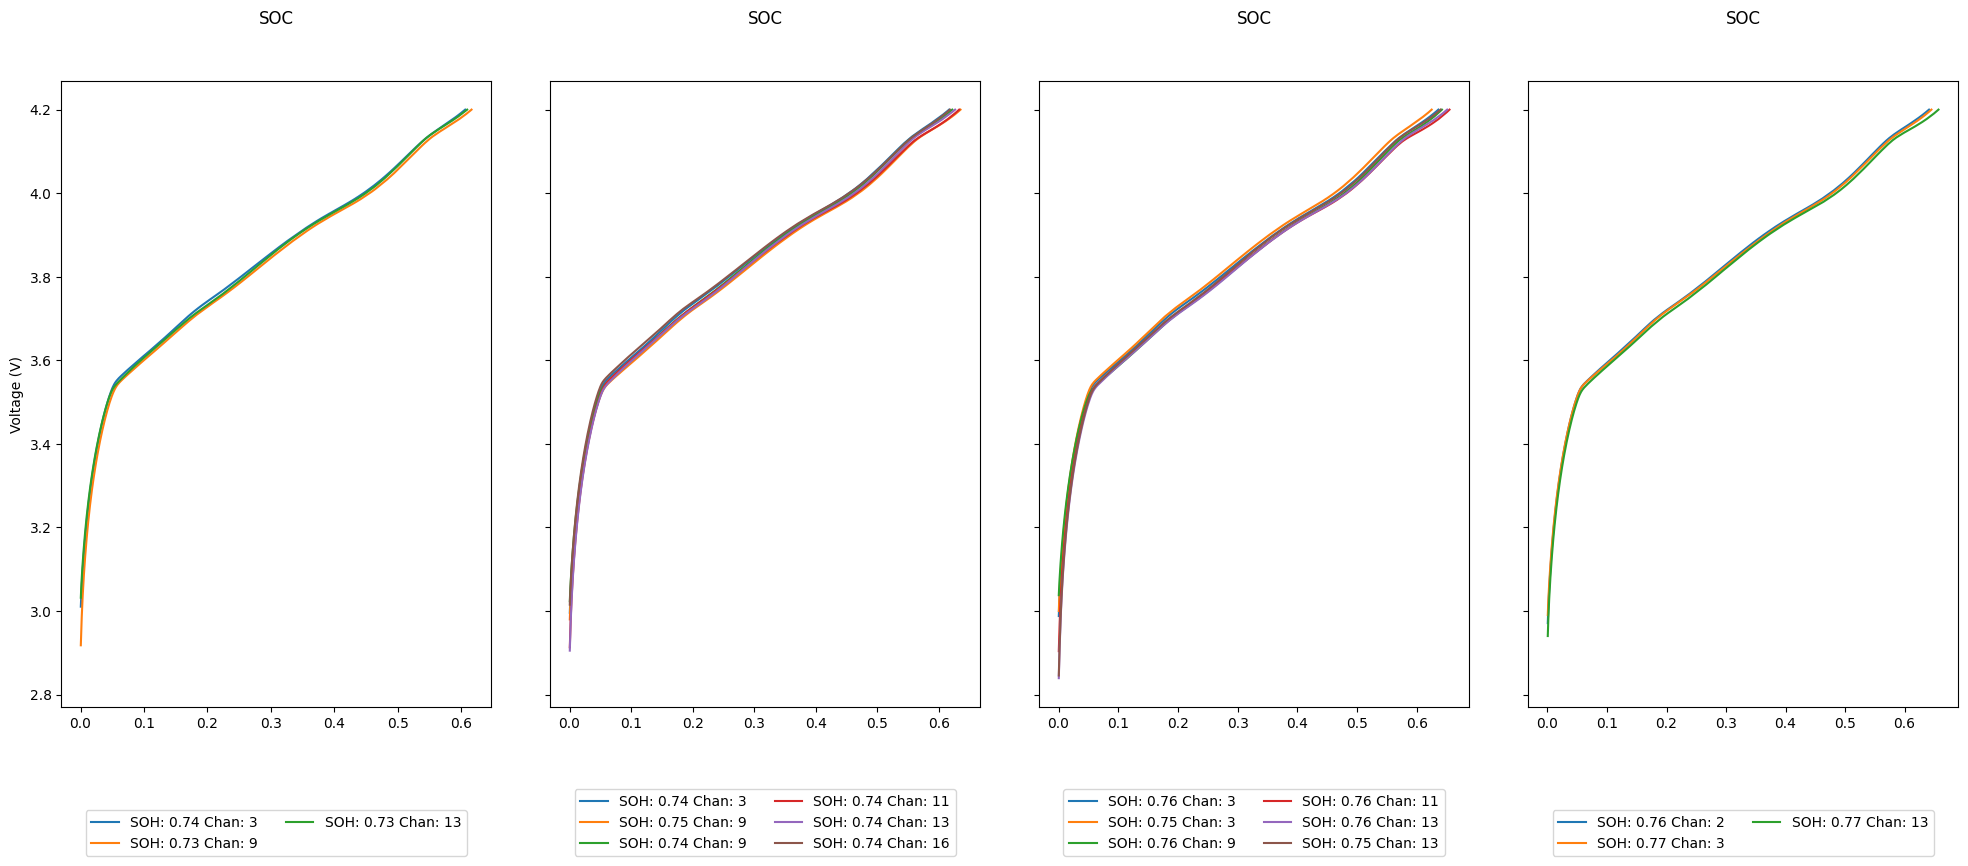

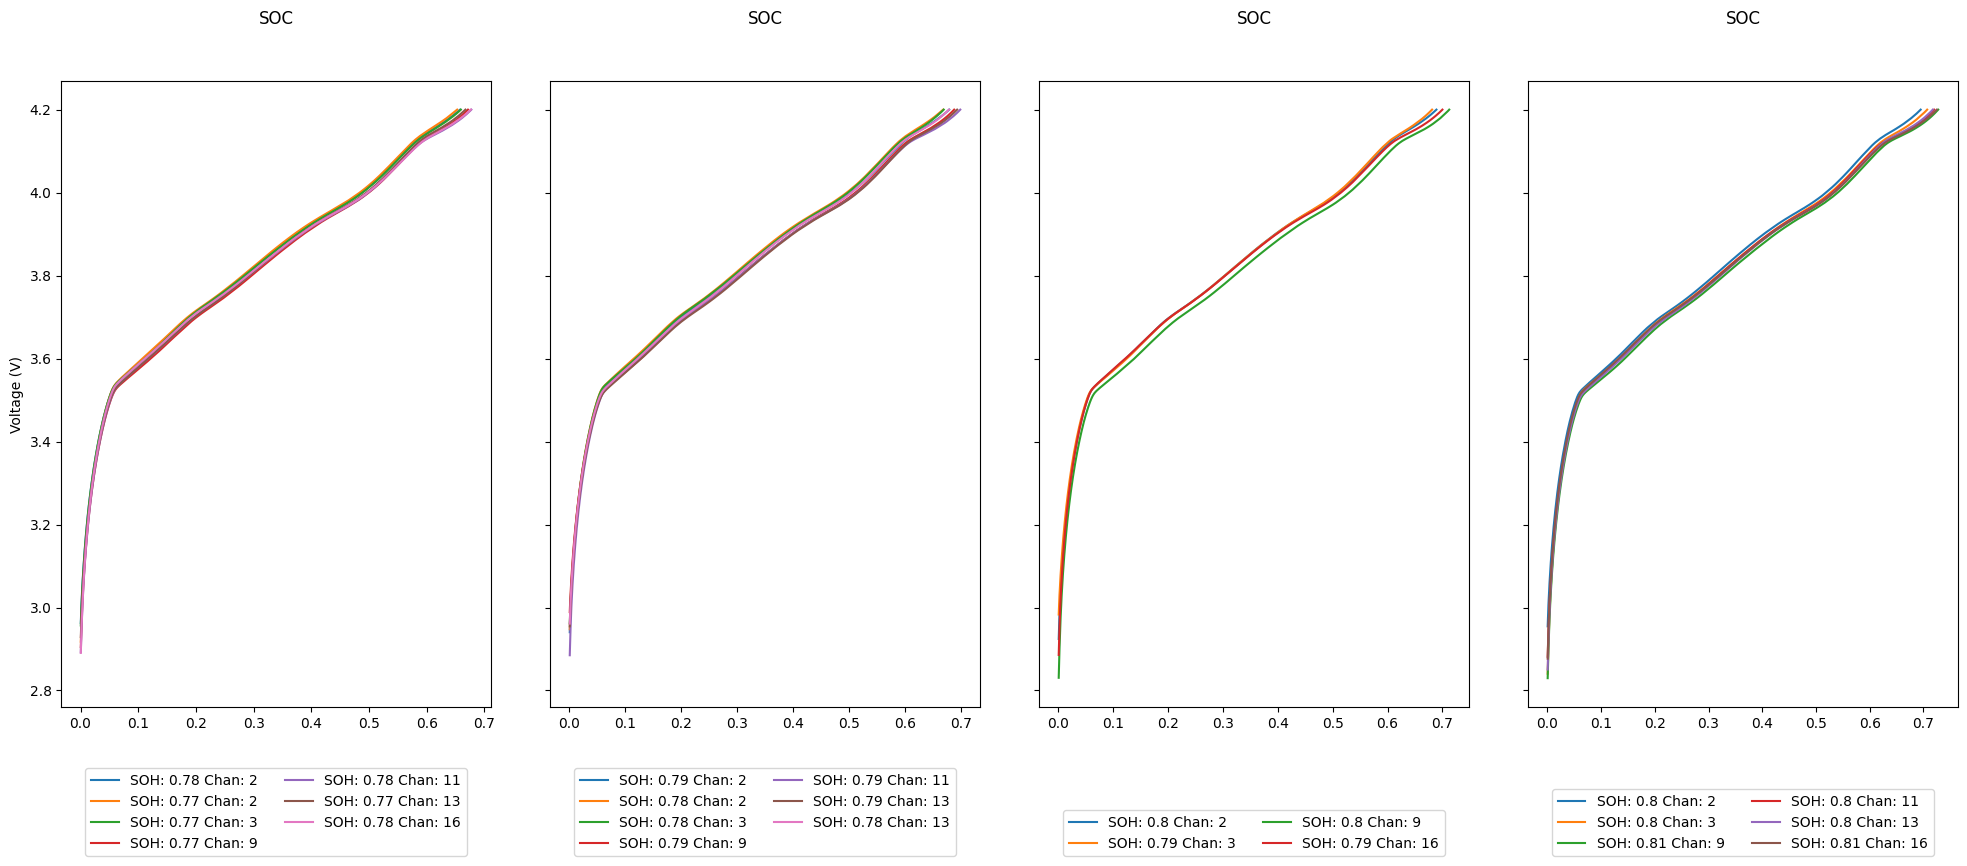

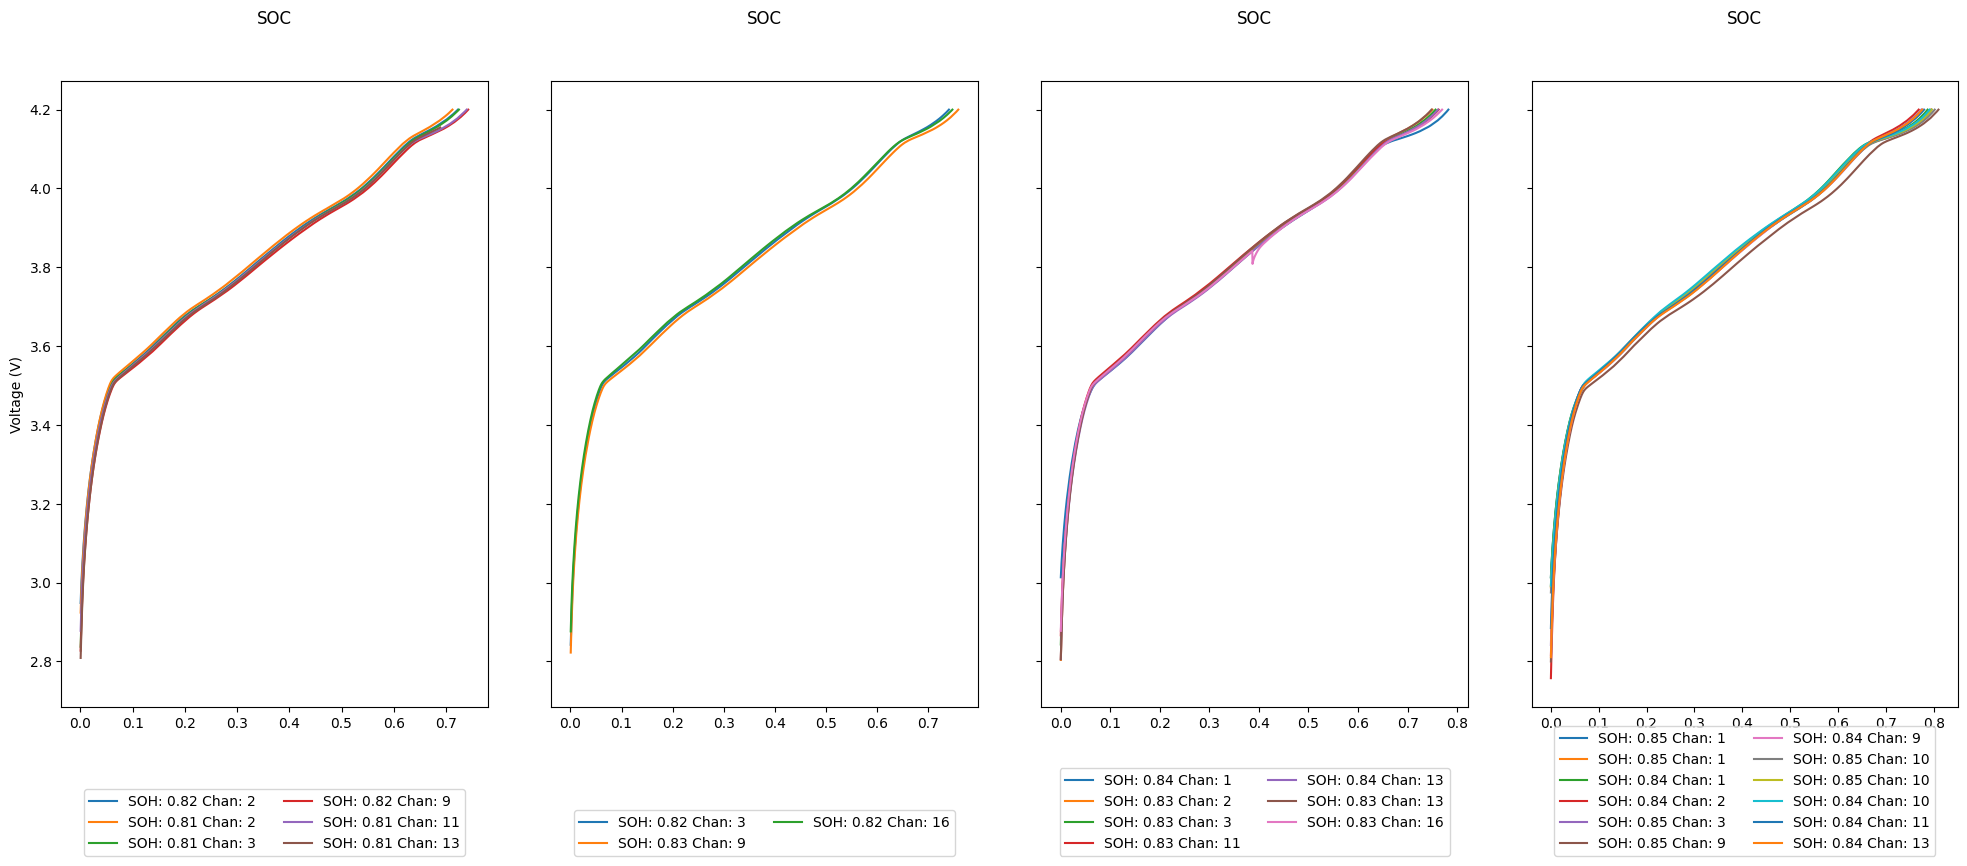

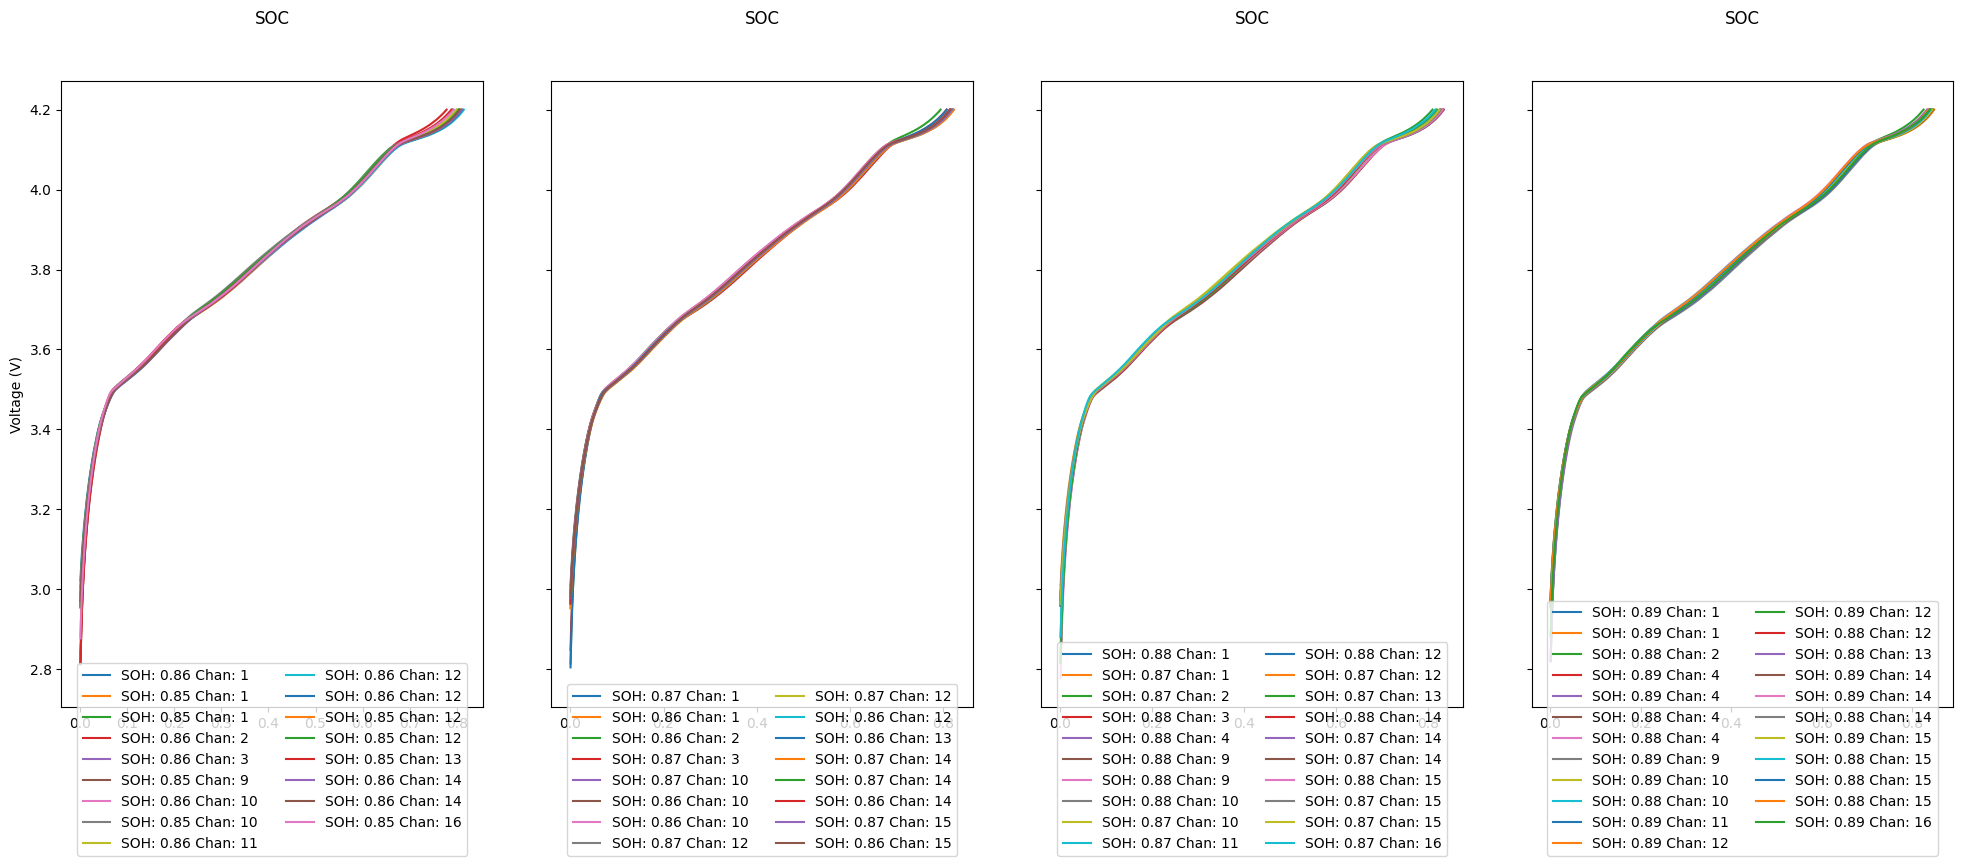

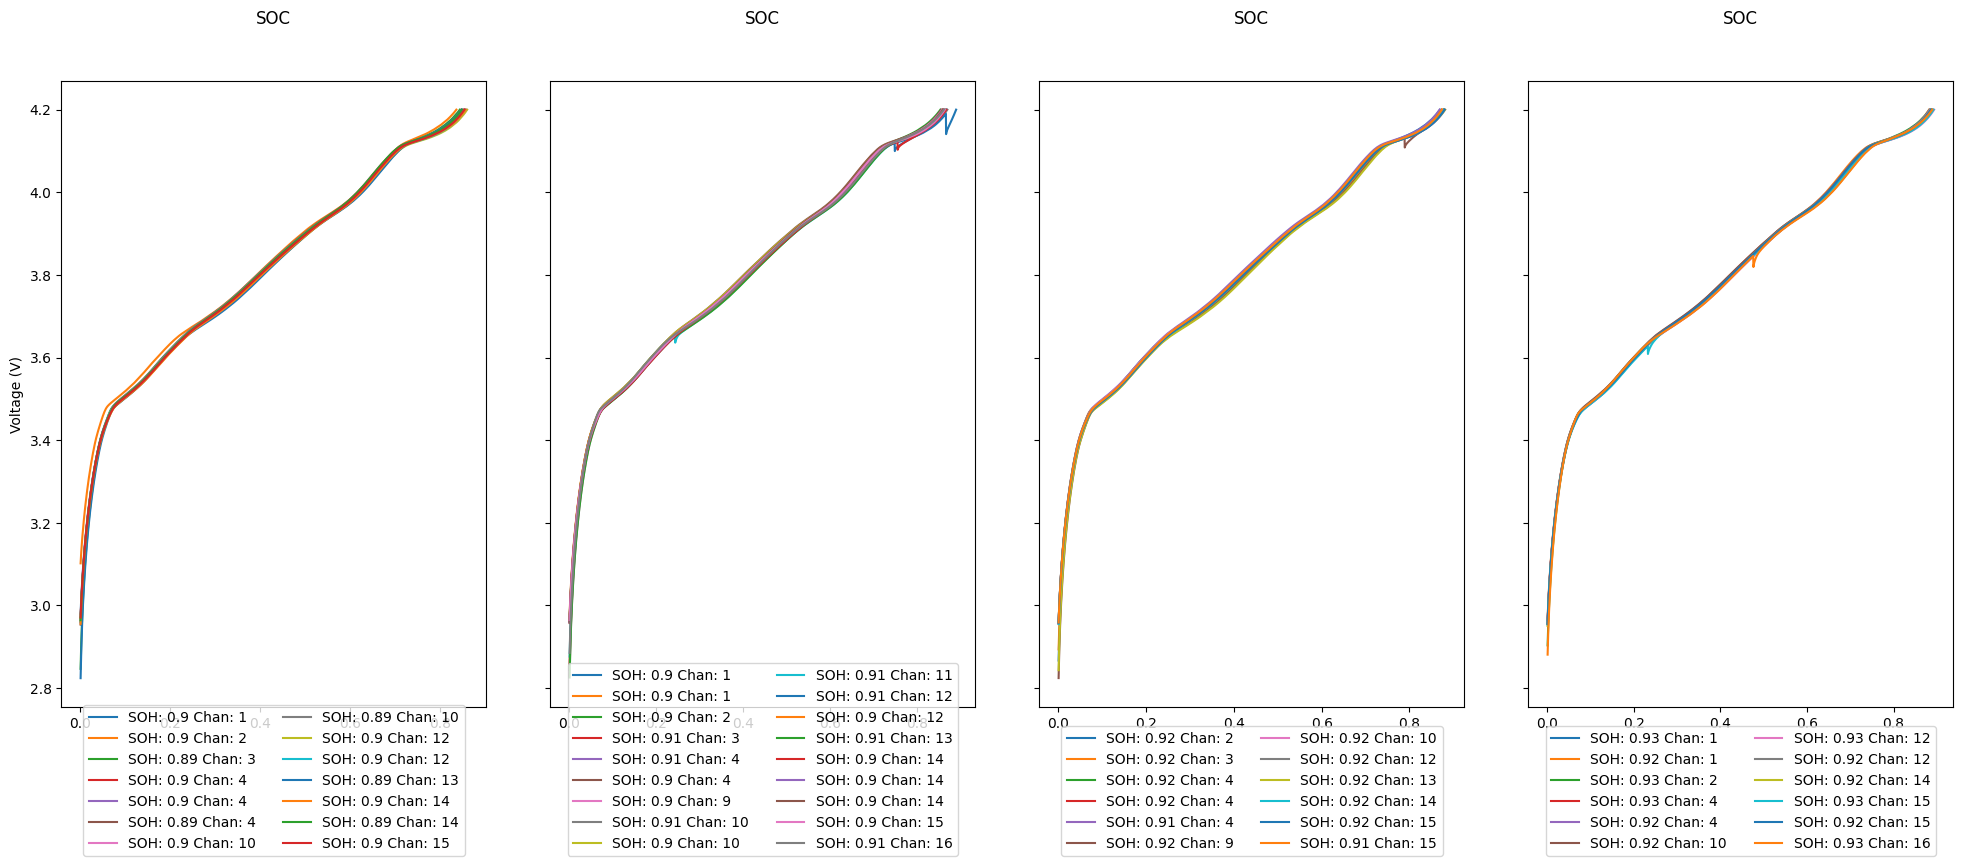

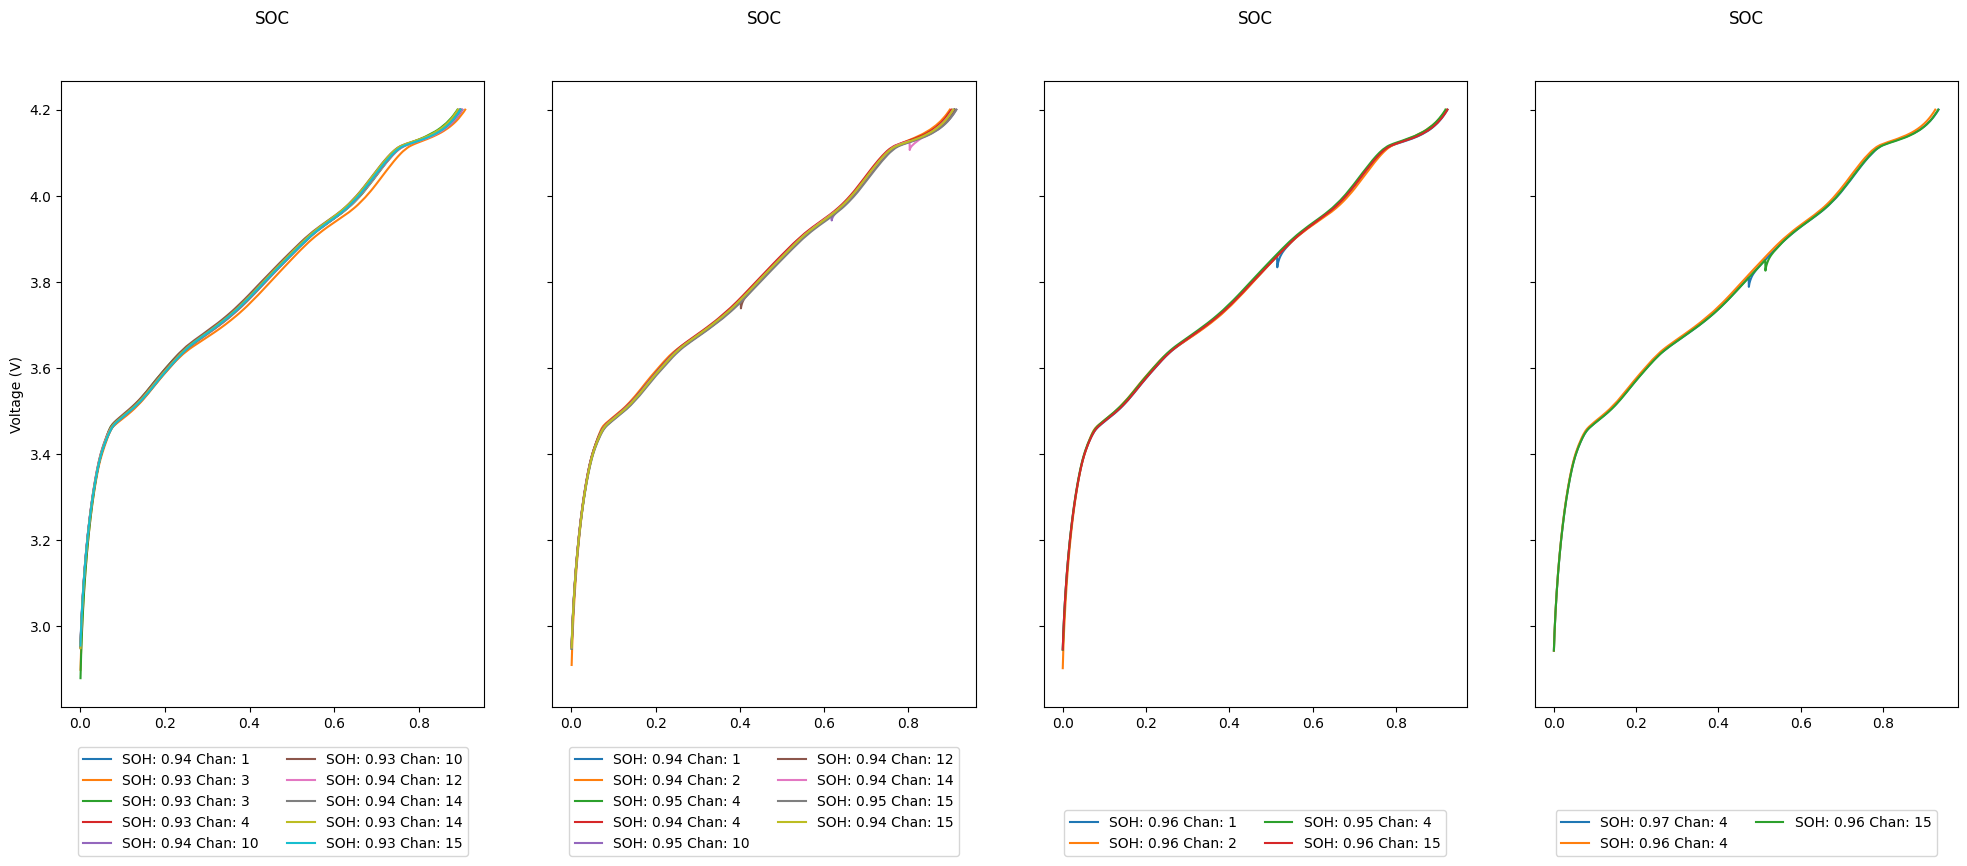

In [17]:
plot_ocv_array(step6_filtered,"Charge_Capacity(Ah)",4)

# Make OCV Lookup Table.

In [52]:
def avg_ocv(actual_ocv: dict, feature: str, nom_cap: float=4):
    ocv = {}
    x = np.linspace(0,1,1000)
    for key, values in actual_ocv.items():
        interp_list = []
        for step in values:
            interp_list.append(
                np.interp(
                    x,
                    np.array(step[feature]) / nom_cap,
                    step["Voltage(V)"]
                )
            )
        interp_list = np.array(interp_list)
        ocv[key] = interp_list.mean(axis=0)
    return ocv

In [53]:
discharge_ocv = avg_ocv(step10_filtered, "Discharge_Capacity(Ah)")
charge_ocv = avg_ocv(step6_filtered, "Charge_Capacity(Ah)")

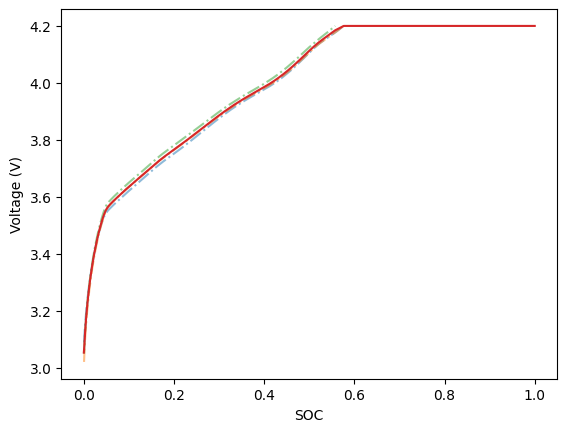

In [60]:
plot_avg_ocv(np.linspace(0,1,1000), charge_ocv, step6_filtered, 0.7, "Charge_Capacity(Ah)")

In [62]:
# save dictionary's to be lookup tables
with open('../lookup_tables/discharge_ocv.pkl', 'wb') as f:
    pickle.dump(discharge_ocv, f)

with open('../lookup_tables/charge_ocv.pkl', 'wb') as f:
    pickle.dump(charge_ocv, f)